# Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Helper Functions

These are few helper functions 

In [ ]:
import math
import cv2 
import time 
import progressbar 
import numpy as np 
from matplotlib import pyplot

def visualize_result( rgb, gt, pred, figsize=(21,7), title=None ) :
    """Visualize raw input, ground truth, and BusterNet result
    """
    pyplot.figure( figsize=figsize )
    pyplot.subplot(131)
    pyplot.imshow( rgb,)
    pyplot.title('input image')
    pyplot.subplot(132)
    pyplot.title('ground truth')
    pyplot.imshow(gt,)
    pyplot.subplot(133)
    pyplot.imshow(pred,)
    pyplot.title('pred')
    if title is not None :
        pyplot.suptitle( title )

In [ ]:
def acc_result2(gt, pred) :
    tp = gt*pred
    fp = pred - tp
    fn = gt - tp
    
    tpC = np.sum(np.round(np.clip(tp,0,1)))
    fpC = np.sum(np.round(np.clip(fp,0,1)))
    fnC = np.sum(np.round(np.clip(fn,0,1)))
    
    return (tpC, fpC, fnC)

In [ ]:
def acc_result(gt, pred, display) :
    tp = gt*pred
    fp = pred - tp
    fn = gt - tp
    tpC = np.sum(np.round(np.clip(gt*pred,0,1)))
    tpfnC = np.sum(np.round(np.clip(gt,0,1)))
    tpfpC = np.sum(np.round(np.clip(pred,0,1)))
    epi = 1e-07
    recall = tpC/(tpfnC + epi)
    precision = tpC/(tpfpC + epi)
    fm = 2*recall*precision/(recall+precision+epi)



    if display:
      pyplot.figure( figsize=(21,7) )
      pyplot.subplot(131)
      pyplot.imshow( fp)
      pyplot.title('False Positive')
      pyplot.subplot(132)
      pyplot.title('False Negative')
      pyplot.imshow(fn)
      pyplot.subplot(133)
      pyplot.imshow(tp)
      pyplot.title('True Positive')
      title = " Precision = " + str(precision) + " Recall = " + str(recall) + " F Measure = " + str(fm)  
      pyplot.suptitle(title)
    
    return (precision,recall,fm)

In [ ]:
from PIL import Image,ImageFilter
import numpy as np

def read(name,size=256):
  img = Image.open(name) 
  numpydata = np.asarray(img) 
  numpydata = numpydata.astype('float')
  numpydata = numpydata/255
  return numpydata

In [ ]:
def convertRGBImageToYUV(imag) :
  img = np.copy(imag)
  r = img[:,:,0]
  g = img[:,:,1]
  b = img[:,:,2]
  y = 0.299*r + 0.587*g + 0.114*b
  u = -0.14713*r - 0.28886*g + 0.436*b
  v = 0.615*r - 0.51498*g - 0.10001*b
  img[:,:,0] = y
  img[:,:,1] = u
  img[:,:,2] = v
  return img

# Read Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256)


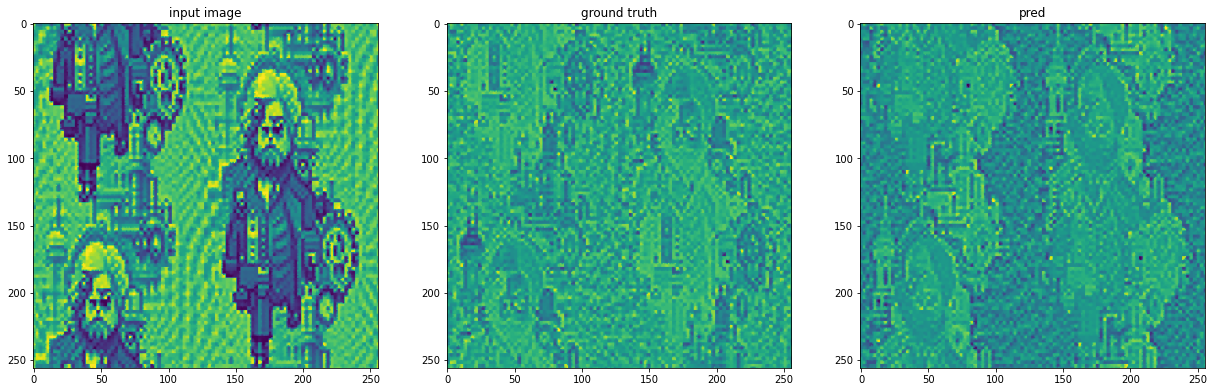

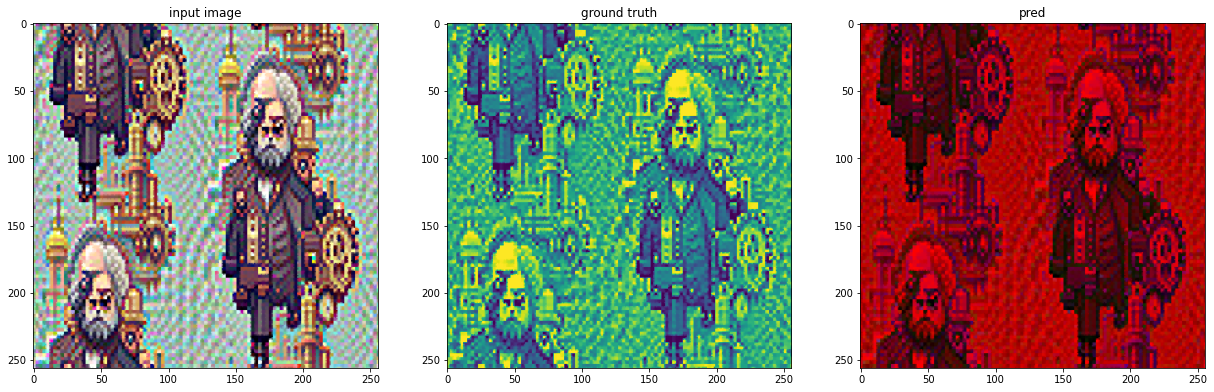

In [ ]:
rgb = read('/content/drive/MyDrive/train dataset/Train Homolode/image/001_F.png')
yuv = convertRGBImageToYUV(rgb)
visualize_result(yuv[:,:,0],yuv[:,:,1],yuv[:,:,2])

gt = read('/content/drive/MyDrive/train dataset/Train Homolode/label/001_B_1.png')

print(gt.shape)
try:
  gt = gt[:,:,0]
except:
  pass
visualize_result(rgb,gt,yuv)
print(gt.shape)

# LTrP


In [ ]:
def channelDir(chn):
  def i0(gcX,gcY):
    return chn[gcY][gcX-1] - chn[gcY][gcX]
  def i90(gcX,gcY):
    return chn[gcY-1][gcX] - chn[gcY][gcX]

  def iDir(gcX,gcY):
    dir0 = i0(gcX,gcY)
    dir90 = i90(gcX,gcY)
    if dir0 >= 0 and dir90 >=0:
      return 1
    if dir0 < 0 and dir90 >=0:
      return 2
    if dir0 < 0 and dir90 <0:
      return 3
    return 4

  shapeA = chn.shape[0]
  shapeB = chn.shape[1]
  out = chn*0
  for i in range(shapeA):
    for j in range(shapeB):
      out[i][j] = iDir(j,i)
  # visualize_result(out,chn,rgb)
  return out

In [ ]:
def LTrPFeature(block, dirMap,x,y):
  cX = int(x)
  cY = int(y)
  def f3(gcX, gcY, gpX, gpY):
    dgp = dirMap[gpY+cY][gpX+cX]
    if dirMap[gcY+cY][gcX+cX] == dgp:
      return 0
    return dgp

  ltrp2 = np.zeros((3,3))

  for i in range(1,4):
    for j in range(1,4):
      ltrp2[i-1][j-1] = f3(2,2,j,i)

  return np.delete(ltrp2.reshape(9),4)

In [ ]:
def LTrPencode(blocks,rgb):
  bar = progressbar.ProgressBar(max_value=blocks.shape[0],).start() # progress bar
  count = 0 #count for progress bar
  features = [] #features list
  yuv = convertRGBImageToYUV(rgb)
  rDir = channelDir(yuv[:,:,0])
  gDir = channelDir(yuv[:,:,1])
  bDir = channelDir(yuv[:,:,2])

  for block in blocks:
    bar.update(count)
    count = count + 1 #progress bar update
    blockX = block[0][0][0] # getting x coord
    blockY = block[1][0][0] # getting y coord
    bc = np.copy(block[2:]) # local copy of the block (r,g,b,y)
    bSize = bc.shape[1] # getting blocksize
    avg = np.sum(bc,axis=-1) 
    avg = np.sum(avg,axis=-1)/(bSize*bSize) # averaging the block, channelwise
    ybc = np.copy(bc[3])
    feature = np.zeros((8,3))
    feature[:,0] = LTrPFeature(bc[0],rDir,blockX,blockY)
    feature[:,1] = LTrPFeature(bc[1],gDir,blockX,blockY)
    feature[:,2] = LTrPFeature(bc[2],bDir,blockX,blockY)
    feature = feature.reshape(24) #np.append(feature.reshape(32),[avg[0], avg[1], avg[2]])

    fX = np.ones(24) * blockX # a 1d array of length 9 to store the x coordinate
    fY = np.ones(24) * blockY # a 1d array of length 9 to store the y coordinate
    features.append(np.array([feature,fX,fY]))    
  features = np.array(features) # converting to numpy vector
  return features

# Main Algorithm

In [ ]:
def divideIntoBlocks(rgb, blockSize = 5):
  height = rgb.shape[0]
  width = rgb.shape[1]
  r = rgb[:,:,0]
  g = rgb[:,:,1]
  b = rgb[:,:,2]
  y= 0.299*r + 0.587*g + 0.114*b # calculating the y component of YUV color space
  img_blocks = []
  for i in range(0,height - blockSize):
    for j in range(0,width - blockSize):
        indx = np.ones((blockSize,blockSize)) * j # 4x4 block consisting entirely of the value of the x coordinate
        indy = np.ones((blockSize,blockSize)) * i # 4x4 block consisting entirely of the value of the y coordinate
        img = np.array([indx,indy,r[i:i+blockSize,j:j+blockSize],g[i:i+blockSize,j:j+blockSize],b[i:i+blockSize,j:j+blockSize],y[i:i+blockSize,j:j+blockSize]])  # calculating a block (coord_x,coord_y,r,g,b,y)
        img_blocks.append(img) # adding each of the blocks to a list
  img_blocks = np.array(img_blocks)
  return img_blocks # returns the length of the list

In [ ]:
def checkNeighbours(x1,y1,x2,y2,predMask):
  A = np.sum(predMask[x1-1:x1+2,y1-1:y1+2]) - 1
  B = np.sum(predMask[x2-1:x2+2,y2-1:y2+2]) - 1
  if A>=6 and B>=6:
    return True
  return False

In [ ]:
def lexiSort(feaMap):
  sorted = []
  onlyfea = feaMap[:,0] #getting only feature vectors, discarding the x and y vectors
  indx = np.lexsort(np.rot90(onlyfea)) # rotating 90 degree to ensure it is sorted row-wise, then lexsorting 
  for i in indx: #indx contains the appropriate order of indices after lexsorting
    sorted.append(feaMap[i]) #appending the entire feature block including feature vector and x and y coordinates to list
  sorted = np.array(sorted) #converting to numpy vector
  return sorted

In [ ]:
def connectedComp(predout,thresY=0,thresX=0,): 
  w = np.where(predout == 1)
  begX = np.min(w[1])
  endX = np.max(w[1])
  begY = np.min(w[0])
  endY = np.max(w[0])
  thresX += (endX-begX)
  thresY += (endY-begY)
  # print(begX, endX)
  # print(begY, endY)
  predx = np.copy(predout)
  for i in range(begX,endX):
    flag = False
    lo = begY
    for j in range(begY,endY):
      if predx[j][i] == 1:
        if flag and (j-lo) < thresY//8:
          predx[lo:j,i] = 1
        flag = True
        lo = j+1
  predy = np.copy(predout)
  for i in range(begY,endY):
    flag = False
    lo = begX
    for j in range(begX,endX):
      if predy[i][j] == 1:
        if flag and (j-lo) < thresX//8:
          predy[i,lo:j] = 1
        flag = True
        lo = j+1

  z = np.clip(predx+predy,0,1)

  predg = z*0
  # predx = np.copy(predout)
  for i in range(begY,endY):
    for j in range(begX,endX):
      if np.sum(z[i-1:i+3,j-1:j+3]) > 1:
        predg[i:i+4,j:j+4] = 1
  # predg[0:(thresY),0:(thresX)]=1
  return predg
    

In [ ]:
def analyzeBlocks(blockA, blockB, simThres = 0.002):
  
  #calculating distance between two matched blocks
  dx = blockA[1][0] - blockB[1][0] 
  dy = blockA[2][0] - blockB[2][0]
  dist = math.sqrt(pow(dx, 2) + pow(dy, 2))
  # phi = int(math.atan2(abs(dx),abs(dy))/math.pi*180)
  #calculating similarity 
  fA = np.sum(blockA[0])
  fB = np.sum(blockB[0])
  dif = abs(fA-fB)

  res = np.array([
    # xa:      
    blockA[1][0],
    # ya:      
    blockA[2][0],
    # xb:      
    blockB[1][0],
    # yb:      
    blockB[2][0],
    # # phi:
    # phi
    # offsetX: 
    abs(dx),
    # offsetY: 
    abs(dy),
  ])

  if dif < simThres: # checking if similar
    if dist >= 10: #checking if not neighbour
      return res
      
  # if dist < distanceThreshold*100 :
  #   return res
  return None

In [ ]:
def checkNeighbours(x1,y1,x2,y2,predMask):
  A = np.sum(predMask[x1-1:x1+2,y1-1:y1+2,0]) - 1
  B = np.sum(predMask[x2-1:x2+2,y2-1:y2+2,1]) - 1
  if A>=4 and B>=4:
    return True
  return False

In [ ]:
def detectSimi(rgb,gt,blockSize=10):
  shapeA = rgb.shape[0]
  shapeB = rgb.shape[1]
  blocks = divideIntoBlocks(rgb,blockSize)

  imgSize = max(shapeA,shapeB)# rgb.shape[0]
  features = LTrPencode(blocks,rgb)

  lsorted = lexiSort(features)
  # # print('sorted shape',lsorted.shape)

  vectors = []
  windowSize = 3
  for i in range(len(lsorted)-windowSize+1):
    for j in range(1,windowSize):
      blockA, blockB = np.copy(lsorted[i]), np.copy(lsorted[i+j]) # get consecutive blocks
      res = analyzeBlocks(blockA,blockB) #check if they match
      if res is not None: #if match found
        vectors.append(res)

  shift = np.zeros((shapeA,shapeB))
  # final = rgb * 0
  for vector in vectors:
    # final[int(vector[1])][int(vector[0])][0] += 1
    # final[int(vector[3])][int(vector[2])][1] += 1
    shift[int(vector[5])][int(vector[4])] += 1


  maxoff = np.max(shift)

  offsetThreshold = 3*maxoff//4


  offset = np.copy(shift)
  offset = offset.astype(int)
  offset[offset <= offsetThreshold] = 0
  offset[offset > offsetThreshold] = 1

  # print(np.max(offset))

  duplicates = []
  for vector in vectors:
    if offset[int(vector[5])][int(vector[4])] == 1:
      duplicates.append(vector)

  final = rgb * 0
  for res in duplicates:
        final[int(res[1])][int(res[0])][0] = 1
        final[int(res[3])][int(res[2])][1] = 1

  final2 = final
  final2 = final2*0
  for vector in duplicates:
    blockAx = int(vector[0])
    blockAy = int(vector[1])
    blockBx = int(vector[2])
    blockBy = int(vector[3])
    # break
    if checkNeighbours(blockAy,blockAx,blockBy,blockBx,final):
      final2[blockAy][blockAx][0] = 1
      final2[blockBy][blockBx][1] = 1
      # outRem.append(vector)
  # visualize_result(rgb,gt,final)
  source = final[:,:,0] * 0
  target = final[:,:,1] * 0
  for i in range(1,shapeA-1):
    for j in range(1,shapeB-1):
      sourceBlock = np.sum(final2[i-1:i+2,j-1:j+2,0])
      targetBlock = np.sum(final2[i-1:i+2,j-1:j+2,1])
      if sourceBlock>4:
        source[i+1:i+4,j+1:j+4] = 1
      if targetBlock>4:
        target[i+1:i+4,j+1:j+4] = 1

  final2 = final*0
  final2[:,:,0] = source
  final2[:,:,1] = target
  predMask = np.clip(np.sum(final2,axis=-1),0,1)

  kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(4,4))
  predOut = cv2.dilate(predMask,kernel1,iterations = 2)

  kernel0 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
  predOut2 = cv2.erode(predMask,kernel0,iterations = 1)

  if np.sum(np.round(np.clip(predOut2,0,1))) < 10:
      predOut = predOut * 0
      
  visualize_result(rgb,gt,predOut)
  acc_result(gt,predOut,True)
  return acc_result2(gt,predOut)

# Test

In [ ]:
detectSimi(rgb,gt,10)

# Computational Complexity

In [ ]:
import os

path1 = '/content/drive/MyDrive/train dataset/Train Homolode/image'

imagelist = list(os.listdir(path1))
imagelist.sort()
imagelist

In [ ]:
path2 = '/content/drive/MyDrive/train dataset/Train Homolode/label'

labellist = list(os.listdir(path2))
labellist.sort()
labellist

In [ ]:
import time

time_count = 0
for i in range(0,1000,25):
  for j in range(13):
    rgb = read(path1 + "/" + imagelist[i+j])
    gt = read(path2 + "/" + labellist[i+j])
    gt = gt[:,:,0]
    start_time = time.time()
    result = detectSimi(rgb,gt,10, True)
    time_count += time.time() - start_time
    print(imagelist[i],labellist[i], result,time_count)

print(time_count)